# PYTHON VERSION

In [1]:
import sys
print(sys.version)

3.6.5 |Anaconda, Inc.| (default, Mar 29 2018, 13:32:41) [MSC v.1900 64 bit (AMD64)]


In [2]:
import numpy as np
import matplotlib.pyplot as plt


np.random.seed(2017)  # for reproducibility

%matplotlib inline

# Simulated Annealing

In this exercise the method of simulated annealing is used
([simulated annealing](https://en.wikipedia.org/wiki/Simulated_annealing)) for
finding the minimum of a function $V: \mathbb{R} \to \mathbb{R}$. 
As an example, the polynomial function below is considered:

$$ V(x) = \frac{x^4}{4} + \frac{7 x^3}{15} + \frac{4 x^2}{5} + \frac{4x}{5} + 2.$$

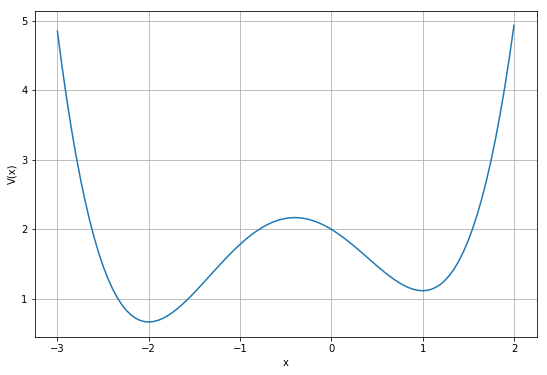

In [3]:
def V(x):
    """Energy (objective) function to minimize"""
    return np.polyval((0.25, 7/15, -0.8, -0.8, 2.0), x)

x = np.linspace(-3, 2, 100)

plt.figure(figsize = (9, 6))
plt.plot(x, V(x))
plt.xlabel("x")
plt.ylabel("V(x)")
plt.grid(True)
plt.show()

As you can see the function is minimized at $x= -2$ and a local minimum t $x = 1$.

The simulated annealing algorithm works as follows. Initially a "particle" is
is randomly placed in the interval $(-3.5, +3.5)$ and has a temperature of $T = 128$. 
At each iteration it attempts a displacement that follows a uniform distribution in the interval 
$(-\delta, +\delta)$ and performs the shift according to the *Metropolis-Hastings* algorithm.
Temperature controls how "flexible" our particle is,
i.e. how easily it accepts shifts $x\to y$ that seem "worse" ($V(y)>V(x)$) than the
current position. 

First we let the particle move freely and explore space (high temperature)
but then, every $n$ steps, we restrict it (lower temperature). 
The idea is that after giving the particle a chance to explore space for some time, as we cool it
it will prefer to visit valleys rather than hills. The goal is to slowly trap
the particle in the deepest valley (near the minimum of the $V$ function.) This process (of gradual cooling) continues until the temperature reaches $T_{min}$

*Note*: The function `np.polyval(p, x)` takes as input a vector `p` and a single value `x`
and computes the polynomial $ p \cdot {(x^d, x^{d-1}, ..., x^0)}^T$ where `d` is the order of `p`. When `x`
is a vector, it computes the polynomial value at the point `x`.

## Algorithm

The next cell contains a simple illustration of this idea.

In [4]:
def sim_anneal(f, x_low, x_high,
               T=2.0, T_min=2**(-12), 
               cool_factor=0.9, cool_sch=100,
               delta = 1.0, shrink_factor=0.5, shrink_thres=0.25,
               trace = False):
    
    # Initialize
    x = np.random.uniform(x_low, x_high)
    f_cur = f(x)  # current value of f
    steps = accepted = 0
    if trace: path = []

    # Main loop
    while T > T_min:
        
        # proposed new position
        x_new = x + np.random.uniform(-delta, delta)
        if x_new > x_high or x_new < x_low:
            continue  # skip this proposal
        f_new = f(x_new)

        # accept/reject jump
        if np.log(np.random.rand()) < -(f_new - f_cur) / T :
            x, f_cur = x_new, f_new
            accepted += 1            
                
        # Cooling
        if steps == cool_sch:  # time for the next cooling
            T *= cool_factor  # cool down
            # Adjust Search Space
            if accepted / steps < shrink_thres:
                delta *= shrink_factor
            steps = accepted = 0
        
        if trace: path.append(x)
        steps += 1        
        
    
    if trace: return path
    return x

The parameters of the `sim_anneal` function are:

* **``f`**: the function to be minimized
* **`x_low, x_high`**: The lower and upper value bounding the minimum
* **``T, T_min`**: The initial and final annealing temperatures
* ** **`cool_factor`**: How much the temperature decreases in each cooling cycle (percentage of the previous one)
* **`cool_sch`**: How many steps to reduce the temperature (%) (% of the total number of times the temperature is reduced (%) (* **`cool_sch`**)
* **`delta`**: "Jumping" radius
* ** **`shrink_factor`**: How much to reduce `delta` if we see that the method is stuck
* ** **`shirnk_thres`**: Percentage of successful jumps below which we consider the particle to be stuck.
* ** **`trace`**: Tracing the whole route or just the final position

Therefore to compute the minimum of the $V$ function in the interval $(-3.5, 3.5)$ the function is executed with the following parameters.

*Note: The whole route of the particle is traced.

In [5]:
# Parameters
T_start, T_end = 2.0, 2**(-12)
cool_sch, cool_factor = 100, 0.99

path = sim_anneal(V, -3.5, 3.5, delta = 1.,
                  T = T_start, T_min = T_end,
                  cool_factor = cool_factor, 
                  cool_sch = cool_sch,
                  trace = True)  # keep the default for the rest

path[-1]  # last position

0.9911873133787367

The next cell visualizes the process.

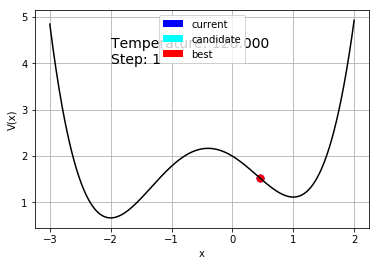

In [6]:
%matplotlib qt
%run animate_simanneal.py -minima 0 

The `animate_simanneal.py` program can accept for arguments:

- **`minima`** selects a polynomial with {0,1,2,3} extrema. 
For zero is the example given
- **`T0`** Initial Temperature (default 128) Initial Temperature
- **`T1`** Final Temperature (default 0.01)
- **`CF`** Percentage of temperature loss at each step (default 0.5)
- **`CS`** Cooling period (default 100)
- **`d`** jump radius (default 3.0)
- **`--delay`** time between frames in ms (default 100)

Try giving other data and see how the annealing behavior changes.

`%matplotlib inline` includes graphs inside the notebook, next to the code.

In [7]:
%matplotlib inline

## Travelling Salesman

The simulated annealing algorithm is used
to solve the [travelling salesman](https://en.wikipedia.org/wiki/Travelling_salesman_problem) problem.

The problem is as follows:

> A salesman wants to visit $N$ cities and return to his base.
What is the shortest route that connects all the cities?

In this exercise cities in Europe are considered.
The file [eu.csv](http://math.ntua.gr/~loulakis/info/python_codes_files/eu.csv) contains 
the geographic longitude and latitude of 27 European cities. The code organizes the information as follows:

* **`city_coord`** a `dictionary` which for each city has the longitude and latitude
* **`Ncities`** the number of cities (27)
* **`city_names`** the names of the cities

The cell below prints the coordinates of Athens for verification.

In [8]:
import csv
import urllib.request

url = "http://math.ntua.gr/~loulakis/info/python_codes_files/eu.csv"
with urllib.request.urlopen(url) as urlstream:
    csvfile = csv.reader(urlstream.read().decode('utf-8').splitlines(), delimiter=",")
    city_coord = {city: tuple(map(float, (longitude, latitude))) 
                  for longitude, latitude, city, _ in csvfile}

Ncities = len(city_coord)  # number of cities
city_names = list(city_coord.keys())
city_coord["Athens"]

(37.97918, 23.716647)

In the next cell the `geodesic_dist` function is defined, which calculates the
distance between 2 cities given their coordinates (credits to [Michael Dunn](http://stackoverflow.com/a/4913653/2167530)) based on the formula [Haversine](https://en.wikipedia.org/wiki/Haversine_formula).

In [9]:
def geodesic_dist(city1, city2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    if city1 == city2:
        return 0.
    lon1, lat1 = np.deg2rad(city1)
    lon2, lat2 = np.deg2rad(city2)
    
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    r = 6371 # Radius of earth in kilometers 6371. Use 3956 for miles
    return c * r

For convenience and speed all the distances are calculated in advance and stored in a table.

In [10]:
# Distance between every pair of cities
dist = np.array([
    [geodesic_dist(coord1, coord2) for coord2 in city_coord.values()]
    for coord1 in city_coord.values()
])

As a convention the initial order of cities is conisedered to be the one which
iteration inside `city_coord` yields:

In [11]:
for i, city in enumerate(city_coord): print(i, city)

0 Brussels
1 Vienna
2 Sofia
3 Nicosia
4 Prague
5 Copenhagen
6 London
7 Helsinki
8 Paris
9 Berlin
10 Athens
11 Budapest
12 Reykjavik
13 Rome
14 Riga
15 Luxembourg
16 Monaco
17 Amsterdam
18 Oslo
19 Warsaw
20 Lisbon
21 Bucharest
22 Moscow
23 Edinburgh
24 Belgrade
25 Madrid
26 Stockholm


## Algorithm

Due to the fact that the path the salesman will follow is circular, it doesn't matter
where he starts from (only which cities he wants to visit matters).
Therefore, our "solution" to the problem is a list of the order in which
one should visit the cities.

Therefore, our goal is to use the technique of simulated annealing to
"search" the space of the permutations of the list of cities in order to
find the permutation that gives the total distance close to the minimum possible.

To run the annealing algorithm 2 elements are necessary:

1. A *energy* function.
2. A way to transition to neighboring states

As an energy function the total distance travelled by the seller is considered (subject to minimizaion).

In [12]:
def total_dist(cities):
    """The total distance covered by the salesman"""
    total = sum(dist[city1][city2] for city1, city2 in zip(cities[:-1], cities[1:]))
    total += dist[cities[-1]][cities[0]] # return to start
    return total

Permutations that differ only in a pair of cities are called neighbouring permutations. 
Therefore, to move in the space of permutations, 2 cities are chosen in random and their 
position in the list is swapped.

To calculate the change in total distance for such a swap, all the distances from the beginning 
can be added up, but obviously something like this is not efficient. For this purpose the function `dist_diff` is defined.
In the next section the logic behind the function is explained.

### Cost of changing visit order

Changing the order of 2 cities is a local change so it is enough to think about which ones are
consequences of this change. *How many distances are affected in total?*

Consider 2 triads of cities randomly within the list:

* $A \to B \to C$ and 
* $X \to Y \to Z$

and without loss of generality consider that the city $B$ appears
before $Y$ in the list.

There are 2 cases, which are listed below.

1. General case $B$ and $Y$ are not adjacent (i.e. $X \not\equiv B$)
2. Specific case $B$ and $Y$ are adjacent (i.e. $X \equiv B$)

The diagram below shows the results of a change between $B$ and $Y$
in these 2 cases.

![TSP Swap Cases](http://math.ntua.gr/~loulakis/info/python_codes_files/tsp_swap.svg)

In [13]:
def dist_diff(ABC, XYZ, tour):
    """
    Differnce of total distance traveled if we swap cities B, Y.
    Input: 2 triplets of nodes A, B, C and X, Y, Z.
    """
    # order
    A, B, C = ABC
    X, Y, Z = XYZ
    # cities
    a, b, c = tour[ABC]
    x, y, z = tour[XYZ]
    
    BpY = (B - Y) % len(tour) # to understand the order
    dx = 0
    
    if BpY != -1 % len(tour):  #  B is not X
        dx += dist[x, b] - dist[x, y] + dist[y, c] - dist[b, c]
    if BpY != 1:  # Y is not A
        dx += dist[a, y] - dist[a, b] + dist[b, z] - dist[y, z]

    return dx

### Implementation

In the following cell an algorithm of the simulated adaptation for the traveling salesman problem is impleneted.

First the parameters of the algorithm are set and some variables to visualize the results. The code is almost identical to the function given earlier. One important difference is that the optimal solution is stored each time. This is done because with a little computational cost a better path can be found that the algorithm explored but did not terminate on it.

In [14]:
# Annealing Parameters
Temp = 10 ** 7
Temp_end = 0.02
cool_factor = 0.95
cool_schedule = 100

# Bookeeping parameters
tour = np.arange(Ncities)  # initial permutation
tour_length = total_dist(tour)  # initial energy level

shortest_tour = np.copy(tour)  # optimal permutation (to be updated)
shortest_tour_length = tour_length  # shortest distance

# To plot later
first_guess = tour_length
running_lengths = []
optimal_lengths = []

# Main loop
while Temp > Temp_end:
    # Constant Temperature Era
    for step in range(cool_schedule):
        # Choose 2 cities to swap
        B, Y = np.random.choice(Ncities, size=2, replace=False)  # index of cities to swap
        ABC = np.array([B-1, B, B+1]) % Ncities  # neighbors of B
        XYZ = np.array([Y-1, Y, Y+1]) % Ncities  # neighbors of Y

        # Compute the energy diffence  
        diff = dist_diff(ABC, XYZ, tour)
        
        # Decide whether to change state.
        if np.log(np.random.rand()) < -diff / Temp:
            tour[B], tour[Y] = tour[Y], tour[B]
            tour_length += diff
            # Keep track of the optimal tour observed
            if tour_length < shortest_tour_length:
                shortest_tour = np.copy(tour)
                shortest_tour_length = tour_length

        running_lengths.append(tour_length)
        optimal_lengths.append(shortest_tour_length)

    Temp *= cool_factor  # cool down

print('Improvement:\t%8.0f%%'  % (100 * (first_guess - shortest_tour_length) / first_guess))
print('Initial distance:\t%.0f km'  % first_guess)
print('Optimal distance:\t%.0f km'  % shortest_tour_length)

Improvement:	      63%
Initial distance:	60608 km
Optimal distance:	22639 km


### results

The evolution of the current optimal solution is plotted below.

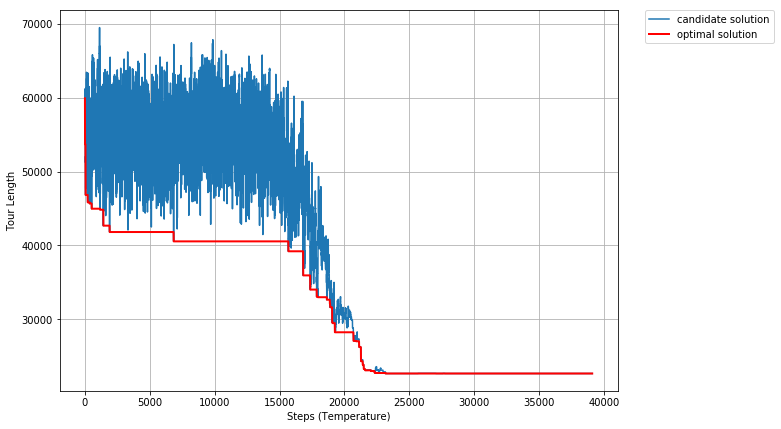

In [15]:
running_lengths = np.array(running_lengths)
optimal_lengths = np.array(optimal_lengths)

plt.figure(figsize = (10, 7))
plt.plot(np.arange(len(running_lengths)), running_lengths, label="candidate solution")
plt.plot(np.arange(len(optimal_lengths)), optimal_lengths, 'r-', linewidth=2, label="optimal solution")

plt.xlabel("Steps (Temperature)")
plt.ylabel("Tour Length")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid()

plt.show()

Finally, with the next code cell a visual representation 
of the optimal path is created.

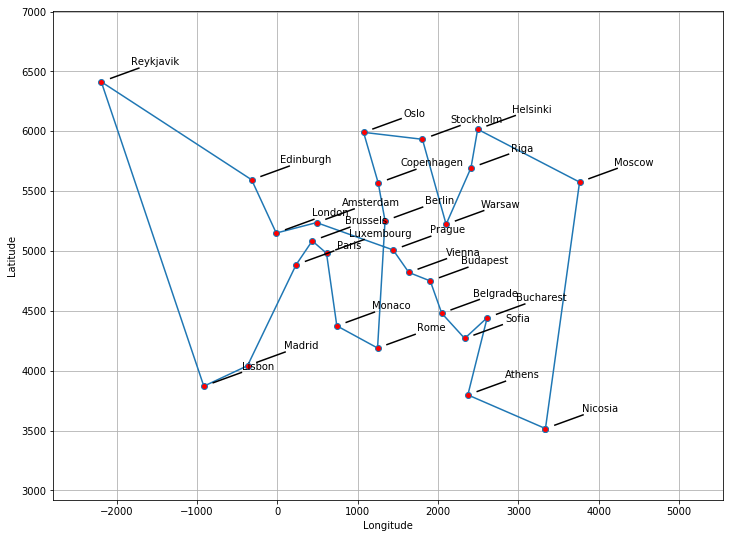

In [16]:
plt.figure(figsize=(12, 9))  # increase image size

# Get Tour Coordinates
coord = np.array([city_coord[city] for city in city_names])
cities = shortest_tour.copy()
cities = np.append(cities, cities[0])
coord = coord[cities,:]  # rearrange

# Scale for better readability
scale_factor = 100
coord = coord * scale_factor

# Plot Tour
plt.plot(coord[:, 1], coord[:,0], 'o-', mfc='r')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid()

# Manage spacing
spacing = np.fabs(min(coord[:,1]) - max(coord[:,1])) * .1
plt.xlim(min(coord[:,1]) - spacing, max(coord[:,1]) + spacing * 3)
plt.ylim(min(coord[:,0]) - spacing, max(coord[:,0]) + spacing)

# Add labels - remove for more clear picture
if len(cities)<=30:
    for i, city in enumerate(cities[:-1]):
        plt.text(coord[i,1], coord[i,0],
                 '%s' % city_names[city],
                 withdash = True,
                 dashdirection = 1,
                 dashlength = 30,
                 rotation = 0,
                 dashrotation = 20,
                 dashpush = 10)
plt.show()

## Application 1

Use the simulated annealing method for the function:

$$ V(x) = \frac{13}{90} x^4 - \frac{3}{10} x^3 - \frac{101}{45} x^2 \frac{13}{15}x + 4.$$

A) Run the algorithm `200` times and calculate the percentage of runs in which 
the algorithm found the total minimum and the percentage in which it found a local minimum
(with a tolerance of 0.05).

B) Run the algorithm `200` times for values of `cool_factor = [0.25, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]` and estimate for each value the probability of the algorithm computing the total minimum. 
Plot the values of `cool_factor` and the probability of computing the total minimum.

In [17]:
# Application 1
import numpy as np
import matplotlib.pyplot as plt


np.random.seed(2017)  # for reproducibility

%matplotlib inline

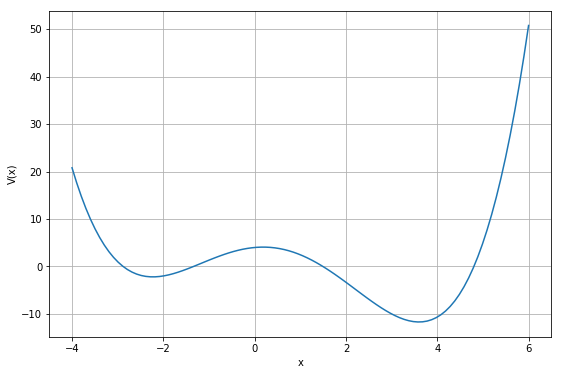

In [18]:
# Question (Α):
# Plotting our function in advance for better visualization of the problem
def V(x):
    """Energy (objective) function to minimize"""
    return np.polyval((13/90, -3/10, -101/45, 13/15, 4.0), x)

x = np.linspace(-4, 6, 100) # Aproximated interval after several trials

plt.figure(figsize = (9, 6))
plt.plot(x, V(x))
plt.xlabel("x")
plt.ylabel("V(x)")
plt.grid(True)
plt.show()

In [19]:
Minimum       =  3.57
Local_Minimum = -2.18 
reps          =  200
tol           =  0.05
MinCount      =  0
LMinCount     =  0
## Parameters
T_start, T_end = 2.0, 2**(-12)
cool_sch, cool_factor = 80, 0.9

for i in range(reps):
    path = sim_anneal(V, -4, 6, delta = 1., # Jump factor 
                      T = T_start, T_min = T_end,
                      cool_factor = cool_factor, 
                      cool_sch = cool_sch,
                      trace = True)  
    if(abs(path[-1]-Minimum)<=abs(tol)):
        MinCount += 1
    
    if(abs(path[-1]-Local_Minimum)<=abs(tol)):
        LMinCount += 1
    
    print(path[-1])
print("The Minimum success percentage, for reps = ", reps, "within the given tolerance = ", tol, "is ", MinCount/reps)
print("The Local Minimum success percentage, for reps = ", reps, "within the given tolerance = ", tol, "is ", LMinCount/reps)

3.596784683407766
-2.229808428725882
3.6001096227167246
3.5991694183362823
3.595193246157843
3.594746135418121
3.5901325559986503
3.613715128833718
3.595350600667379
-2.2296862703006113
3.5968536653346077
3.5987178894349285
3.5937774439125607
3.6013078997792105
-2.228822532108665
3.599624414137573
3.5977830578314176
3.5989032117537914
3.5980445917286965
3.5997858978002566
3.5991291719114185
3.5975127057969
3.597669386558949
3.602125545558918
3.602324625886972
3.5986425333576917
-2.222065071041559
-2.2334912980886608
3.604730558878028
3.6045888611239065
3.6023875496259596
3.5959944526467513
3.612357951607134
3.5984710334772116
3.601995661675484
-2.2278276706722986
-2.2244674737781636
-2.2259042749111053
3.6052922903251106
3.5994896705941017
3.606478145119985
-2.229858759086867
3.604368767842244
3.602532201821945
3.5991537585612665
3.5979326112246723
3.607344072259981
3.6005975688448504
3.5956198019603196
3.600228167774009
3.6006933390135734
3.5964176874560234
3.597787769246997
3.6055909

In [20]:
# Question (Β):
Minimum       =  3.57
reps          =  200
tol           =  0.05
COOL_FACTOR   = [0.25, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]
PERCENTAGE    = []
## Parameters
T_start, T_end = 2.0, 2**(-12)
cool_sch = 80          # Refresh rate = 80 steps...
for cool_factor in COOL_FACTOR:
    MinCount      =  0 # Initialize for every different cool_factor value...
    for i in range(reps):
        path = sim_anneal(V, -4, 6, delta = 1., # Jump factor 
                          T = T_start, T_min = T_end,
                          cool_factor = cool_factor, 
                          cool_sch = cool_sch,
                          trace = True)  
        if(abs(path[-1]-Minimum)<=abs(tol)):
            MinCount += 1 
    PERCENTAGE.append(MinCount/reps)
    print("The Minimum success percentage, for reps = ", reps, ", tolerance = ", tol, " and cool factor =", cool_factor, "is ", MinCount/reps)

The Minimum success percentage, for reps =  200 , tolerance =  0.05  and cool factor = 0.25 is  0.65
The Minimum success percentage, for reps =  200 , tolerance =  0.05  and cool factor = 0.5 is  0.66
The Minimum success percentage, for reps =  200 , tolerance =  0.05  and cool factor = 0.6 is  0.68
The Minimum success percentage, for reps =  200 , tolerance =  0.05  and cool factor = 0.7 is  0.68
The Minimum success percentage, for reps =  200 , tolerance =  0.05  and cool factor = 0.8 is  0.755
The Minimum success percentage, for reps =  200 , tolerance =  0.05  and cool factor = 0.9 is  0.735
The Minimum success percentage, for reps =  200 , tolerance =  0.05  and cool factor = 0.95 is  0.885
The Minimum success percentage, for reps =  200 , tolerance =  0.05  and cool factor = 0.99 is  0.995


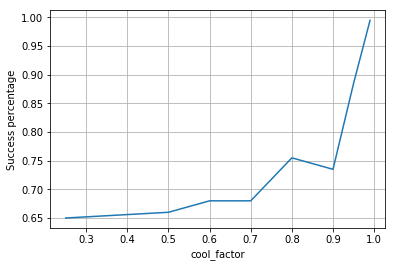

In [21]:
## Plotting
plt.plot(COOL_FACTOR, PERCENTAGE)
plt.xlabel("cool_factor")
plt.ylabel("Success percentage")
plt.grid(True)
plt.show()

## Application 2

(A) Try to improve the solution above by tweaking the code parameters.

(B) Run the travelling salesman code for 35 cities in Europe.
    The data can be found in this address:

        `http://math.ntua.gr/~loulakis/info/python_codes_files/europe.csv`)

Plot the graphs for the evolution of the current optimal solution and for the proposed path in both cases.

C) In a text cell, answer the following questions:

1. How many possible paths pass through all 35 cities only once? 

2. If using a computer the time required to calculate the total length of such a path is 1µsec, how much time would it take to find the optimal path using a brute force algorithm that would calculate the total distance traveled by the traveling salesman along each path and to return the path with the minimum total distance?

In [23]:
# Application 2
# Question (Α):
import csv
import urllib.request

url = "http://math.ntua.gr/~loulakis/info/python_codes_files/eu.csv"
with urllib.request.urlopen(url) as urlstream:
    csvfile = csv.reader(urlstream.read().decode('utf-8').splitlines(), delimiter=",")
    city_coord = {city: tuple(map(float, (longitude, latitude))) 
                  for longitude, latitude, city, _ in csvfile}

Ncities = len(city_coord)  # number of cities
city_names = list(city_coord.keys())
                  
# Distance between every pair of cities
dist = np.array([
    [geodesic_dist(coord1, coord2) for coord2 in city_coord.values()]
    for coord1 in city_coord.values()
])


In [24]:
# Annealing Parameters
Temp = 10 ** 7
Temp_end = 0.02
cool_factor = 0.95
cool_schedule = 800

# Bookeeping parameters
tour = np.arange(Ncities)  # initial permutation
tour_length = total_dist(tour)  # initial energy level

shortest_tour = np.copy(tour)  # optimal permutation (to be updated)
shortest_tour_length = tour_length  # shortest distance

# To plot later
first_guess = tour_length
running_lengths = []
optimal_lengths = []

# Main loop
while Temp > Temp_end:
    # Constant Temperature Era
    for step in range(cool_schedule):
        # Choose 2 cities to swap
        B, Y = np.random.choice(Ncities, size=2, replace=False)  # index of cities to swap
        ABC = np.array([B-1, B, B+1]) % Ncities  # neighbors of B
        XYZ = np.array([Y-1, Y, Y+1]) % Ncities  # neighbors of Y

        # Compute the energy diffence  
        diff = dist_diff(ABC, XYZ, tour)
        
        # Decide whether to change state.
        if np.log(np.random.rand()) < -diff / Temp:
            tour[B], tour[Y] = tour[Y], tour[B]
            tour_length += diff
            # Keep track of the optimal tour observed
            if tour_length < shortest_tour_length:
                shortest_tour = np.copy(tour)
                shortest_tour_length = tour_length

        running_lengths.append(tour_length)
        optimal_lengths.append(shortest_tour_length)

    Temp *= cool_factor  # cool down

print('Improvement:\t%8.0f%%'  % (100 * (first_guess - shortest_tour_length) / first_guess))
print('Initial distance:\t%.0f km'  % first_guess)
print('Optimal distance:\t%.0f km'  % shortest_tour_length)

Improvement:	      63%
Initial distance:	60608 km
Optimal distance:	22644 km


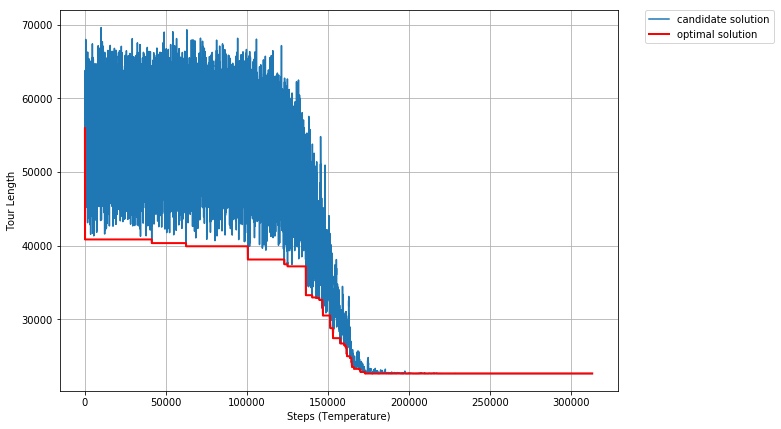

In [25]:
## Plotting
running_lengths = np.array(running_lengths)
optimal_lengths = np.array(optimal_lengths)

plt.figure(figsize = (10, 7))
plt.plot(np.arange(len(running_lengths)), running_lengths, label="candidate solution")
plt.plot(np.arange(len(optimal_lengths)), optimal_lengths, 'r-', linewidth=2, label="optimal solution")

plt.xlabel("Steps (Temperature)")
plt.ylabel("Tour Length")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid()

plt.show()

In [26]:
# Questions 2 & 3:
###########################################################################################
url = "http://math.ntua.gr/~loulakis/info/python_codes_files/europe.csv" # New URL...
with urllib.request.urlopen(url) as urlstream:
    csvfile = csv.reader(urlstream.read().decode('utf-8').splitlines(), delimiter=",")
    city_coord = {city: tuple(map(float, (longitude, latitude))) 
                  for longitude, latitude, city, _ in csvfile}

Ncities = len(city_coord)  # number of cities
city_names = list(city_coord.keys())
###########################################################################################
# Distance between every pair of cities
dist = np.array([
    [geodesic_dist(coord1, coord2) for coord2 in city_coord.values()]
    for coord1 in city_coord.values()
])

In [27]:
# Annealing Parameters
Temp = 10 ** 7
Temp_end = 0.02
cool_factor = 0.95
cool_schedule = 100

# Bookeeping parameters
tour = np.arange(Ncities)  # initial permutation
tour_length = total_dist(tour)  # initial energy level

shortest_tour = np.copy(tour)  # optimal permutation (to be updated)
shortest_tour_length = tour_length  # shortest distance

# To plot later
first_guess = tour_length
running_lengths = []
optimal_lengths = []

# Main loop
while Temp > Temp_end:
    # Constant Temperature Era
    for step in range(cool_schedule):
        # Choose 2 cities to swap
        B, Y = np.random.choice(Ncities, size=2, replace=False)  # index of cities to swap
        ABC = np.array([B-1, B, B+1]) % Ncities  # neighbors of B
        XYZ = np.array([Y-1, Y, Y+1]) % Ncities  # neighbors of Y

        # Compute the energy diffence  
        diff = dist_diff(ABC, XYZ, tour)
        
        # Decide whether to change state.
        if np.log(np.random.rand()) < -diff / Temp:
            tour[B], tour[Y] = tour[Y], tour[B]
            tour_length += diff
            # Keep track of the optimal tour observed
            if tour_length < shortest_tour_length:
                shortest_tour = np.copy(tour)
                shortest_tour_length = tour_length

        running_lengths.append(tour_length)
        optimal_lengths.append(shortest_tour_length)

    Temp *= cool_factor  # cool down

print('Improvement:\t%8.0f%%'  % (100 * (first_guess - shortest_tour_length) / first_guess))
print('Initial distance:\t%.0f km'  % first_guess)
print('Optimal distance:\t%.0f km'  % shortest_tour_length)

Improvement:	      67%
Initial distance:	100118 km
Optimal distance:	33149 km


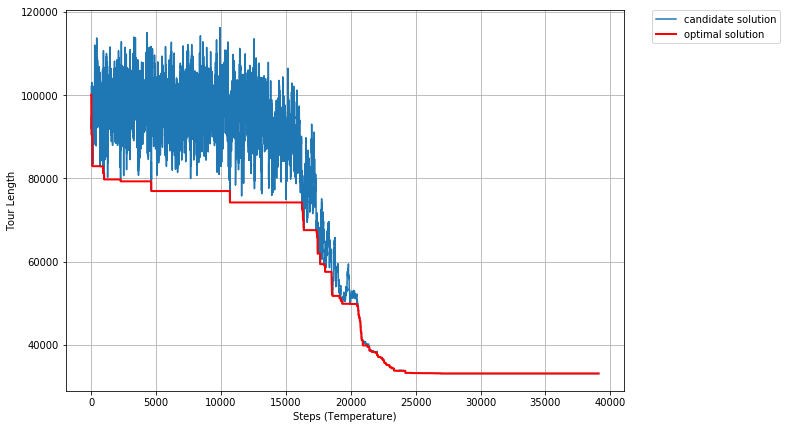

In [28]:
#Plotting
running_lengths = np.array(running_lengths)
optimal_lengths = np.array(optimal_lengths)

plt.figure(figsize = (10, 7))
plt.plot(np.arange(len(running_lengths)), running_lengths, label="candidate solution")
plt.plot(np.arange(len(optimal_lengths)), optimal_lengths, 'r-', linewidth=2, label="optimal solution")

plt.xlabel("Steps (Temperature)")
plt.ylabel("Tour Length")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid()

plt.show()

#### Question (C) 
1. The possible paths passing through all 35 cities exactly one time are equal to `35! ≈ 1.033314797x10^40` i.e. the total number of the permutations of the 35 cities. 

2. Hypothetically if the time cost for calculating the distance for one path is 1ms, then calculating the distance of all possible paths takes approximately `1.033314797x10^40μs = 1.033314797x10^34s` which is a huge number.